In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import statsmodels.api as sm


In [2]:
data=pd.read_csv("Stock Market Dataset.csv")
print(data.columns)
print(data.head())

Index(['Unnamed: 0', 'Date', 'Natural_Gas_Price', 'Natural_Gas_Vol.',
       'Crude_oil_Price', 'Crude_oil_Vol.', 'Copper_Price', 'Copper_Vol.',
       'Bitcoin_Price', 'Bitcoin_Vol.', 'Platinum_Price', 'Platinum_Vol.',
       'Ethereum_Price', 'Ethereum_Vol.', 'S&P_500_Price', 'Nasdaq_100_Price',
       'Nasdaq_100_Vol.', 'Apple_Price', 'Apple_Vol.', 'Tesla_Price',
       'Tesla_Vol.', 'Microsoft_Price', 'Microsoft_Vol.', 'Silver_Price',
       'Silver_Vol.', 'Google_Price', 'Google_Vol.', 'Nvidia_Price',
       'Nvidia_Vol.', 'Berkshire_Price', 'Berkshire_Vol.', 'Netflix_Price',
       'Netflix_Vol.', 'Amazon_Price', 'Amazon_Vol.', 'Meta_Price',
       'Meta_Vol.', 'Gold_Price', 'Gold_Vol.'],
      dtype='object')
   Unnamed: 0        Date  Natural_Gas_Price  Natural_Gas_Vol.  \
0           0  02-02-2024              2.079               NaN   
1           1  01-02-2024              2.050          161340.0   
2           2  31-01-2024              2.100          142860.0   
3         

In [3]:
data=data.drop(columns="Date")
data = data.replace(',', '', regex=True).astype(float)
for column in data.columns:
    print(column)
    print(data[column].dtype)

Unnamed: 0
float64
Natural_Gas_Price
float64
Natural_Gas_Vol.
float64
Crude_oil_Price
float64
Crude_oil_Vol.
float64
Copper_Price
float64
Copper_Vol.
float64
Bitcoin_Price
float64
Bitcoin_Vol.
float64
Platinum_Price
float64
Platinum_Vol.
float64
Ethereum_Price
float64
Ethereum_Vol.
float64
S&P_500_Price
float64
Nasdaq_100_Price
float64
Nasdaq_100_Vol.
float64
Apple_Price
float64
Apple_Vol.
float64
Tesla_Price
float64
Tesla_Vol.
float64
Microsoft_Price
float64
Microsoft_Vol.
float64
Silver_Price
float64
Silver_Vol.
float64
Google_Price
float64
Google_Vol.
float64
Nvidia_Price
float64
Nvidia_Vol.
float64
Berkshire_Price
float64
Berkshire_Vol.
float64
Netflix_Price
float64
Netflix_Vol.
float64
Amazon_Price
float64
Amazon_Vol.
float64
Meta_Price
float64
Meta_Vol.
float64
Gold_Price
float64
Gold_Vol.
float64


In [4]:
data['Gold_Price'] = data['Gold_Price'].astype('float64')
data['Berkshire_Price'] = data['Berkshire_Price'].astype('float64')
data['Bitcoin_Price'] = data['Bitcoin_Price'].astype('float64')
data['Platinum_Price'] = data['Platinum_Price'].astype('float64')
data['Ethereum_Price'] = data['Ethereum_Price'].astype('float64')
data['S&P_500_Price'] =data['S&P_500_Price'].astype('float64')
data['Nasdaq_100_Price'] =data['Nasdaq_100_Price'].astype('float64')

In [5]:
#finding empty values 
empty_values = data.isna().sum()
print(empty_values)

Unnamed: 0             0
Natural_Gas_Price      0
Natural_Gas_Vol.       4
Crude_oil_Price        0
Crude_oil_Vol.        23
Copper_Price           0
Copper_Vol.           37
Bitcoin_Price          0
Bitcoin_Vol.           0
Platinum_Price         0
Platinum_Vol.        607
Ethereum_Price         0
Ethereum_Vol.          0
S&P_500_Price          0
Nasdaq_100_Price       0
Nasdaq_100_Vol.        1
Apple_Price            0
Apple_Vol.             0
Tesla_Price            0
Tesla_Vol.             0
Microsoft_Price        0
Microsoft_Vol.         0
Silver_Price           0
Silver_Vol.           47
Google_Price           0
Google_Vol.            0
Nvidia_Price           0
Nvidia_Vol.            0
Berkshire_Price        0
Berkshire_Vol.         0
Netflix_Price          0
Netflix_Vol.           0
Amazon_Price           0
Amazon_Vol.            0
Meta_Price             0
Meta_Vol.              0
Gold_Price             0
Gold_Vol.              2
dtype: int64


In [6]:
# -----------------------------------------------
# STEP 1: CREATE THE ORIGINAL BROWNIAN MOTION DATA
# -----------------------------------------------
# You create a simple Brownian motion (random walk) by cumulatively summing random steps.
np.random.seed(42)
n = 300
steps = np.random.normal(loc=0, scale=1, size=n)
brownian = np.cumsum(steps)

# ------------------------------------------------
# STEP 2: INTRODUCE MULTIPLE MISSING VALUE REGIONS
# ------------------------------------------------
# Here, you introduce several disjoint intervals of missing values.
# This simulates real-world scenarios where data might be missing in multiple places.
brownian_with_nans = brownian.copy()
missing_regions = [(50, 55), (100, 102), (200, 205)]
for start, end in missing_regions:
    brownian_with_nans[start:end] = np.nan

In [7]:
# (2) Average of Neighbors:
# For each missing value, you will replace it with the average of its immediate neighbors.
# You need to handle ALL missing intervals, not just the first one.
brownian_avg = brownian_with_nans.copy()
for start, end in missing_regions:
    for i in range(start, end):
        if i > 0 and i < len(brownian_avg)-1:
            # Take average of the value before and after the missing point
            left_val = brownian_avg[i-1]
            right_val = brownian_avg[i+1]
            # Only fill if both neighbors are not NaN, otherwise, skip or handle differently
            if not np.isnan(left_val) and not np.isnan(right_val):
                brownian_avg[i] = 0.5*(left_val + right_val)
            else:
                # If a neighbor is also missing, you could choose another strategy,
                # such as forward fill or skip. For simplicity, let's forward fill here.
                brownian_avg[i] = brownian_avg[i-1]

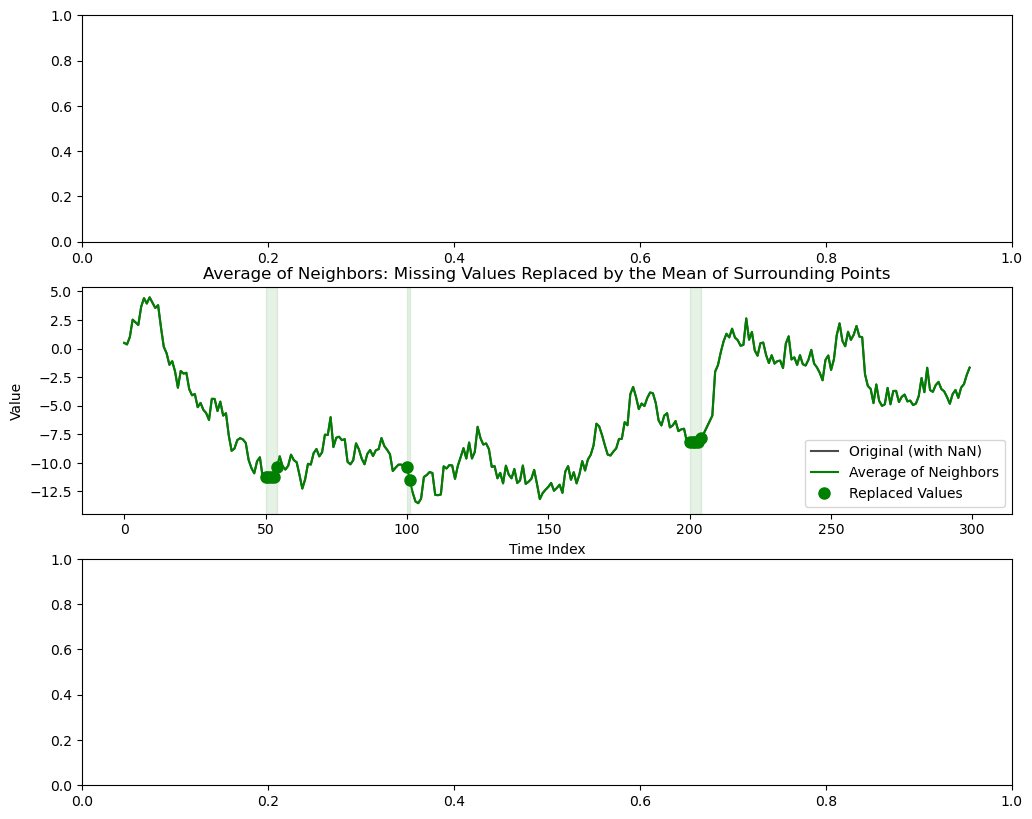

In [8]:

# ---------------------------------------------------
# STEP 4: VISUALIZATION
# ---------------------------------------------------
# You will create a subplot for each method to compare the original data (with NaNs) and the filled data.
# In each subplot:
# - The original data (with NaNs) is shown as a black line with gaps.
# - The filled data is shown in a distinct color line.
# - The missing regions are highlighted with a shaded area.
# - The replaced (filled-in) values are marked with a distinct marker in the same color as the line to draw attention.

fig, axs = plt.subplots(3, 1, figsize=(12, 10))

# To make it easier to highlight all missing regions consistently, let's do a small helper function:
def highlight_missing_regions(ax, regions, color):
    for (start, end) in regions:
        # Highlight the missing region with a transparent shaded rectangle
        ax.axvspan(start, end-1, color=color, alpha=0.1)

def mark_filled_points(ax, original_with_nans, filled_data, regions, marker_color, marker_style):
    # Mark each originally missing value now filled
    for (start, end) in regions:
        missing_x = np.arange(start, end)
        # The filled values at these indices
        missing_y = filled_data[start:end]
        ax.plot(missing_x, missing_y, marker_style, color=marker_color, markersize=8,
                label='Replaced Values' if start == regions[0][0] else None)# Subplot 2: Average of Neighbors
# ----------------------------
# Plot original
axs[1].plot(brownian_with_nans, color='black', alpha=0.7, label='Original (with NaN)')
# Plot filled result
axs[1].plot(brownian_avg, color='green', label='Average of Neighbors')
highlight_missing_regions(axs[1], missing_regions, 'green')
mark_filled_points(axs[1], brownian_with_nans, brownian_avg, missing_regions, 'green', 'o')

axs[1].set_title("Average of Neighbors: Missing Values Replaced by the Mean of Surrounding Points")
axs[1].set_xlabel("Time Index")
axs[1].set_ylabel("Value")
axs[1].legend()


In [9]:
import numpy as np
import pandas as pd

def fill_avg_neighbors(series):
    series = series.copy()
    nan_indices = np.where(series.isna())[0]  # Get all NaN indices
    
    for i in nan_indices:
        if i==0:
            if np.isnan(series[i]):
                series[i]=series[i+1]
        if i > 0 and i < len(series) - 1:  # Ensure it's not at boundaries
            left_val = series[i - 1]
            right_val = series[i + 1]
            
            if not np.isnan(left_val) and not np.isnan(right_val):
                series[i] = 0.5 * (left_val + right_val)
            else:
                # If no valid neighbors, fallback to forward fill (or backward if at start)
                if i > 0:
                    series[i] = series[i - 1]  # Forward fill
                else:
                    series[i] = series[i + 1]  # Backward fill for first row NaN
                    
    return series

# Apply this function to all numeric columns
data = data.apply(fill_avg_neighbors, axis=0)


In [10]:
print(type(data.isna()))
empty_values = data.isna().sum()
print(empty_values)

<class 'pandas.core.frame.DataFrame'>
Unnamed: 0            0
Natural_Gas_Price     0
Natural_Gas_Vol.      0
Crude_oil_Price       0
Crude_oil_Vol.        0
Copper_Price          0
Copper_Vol.          26
Bitcoin_Price         0
Bitcoin_Vol.          0
Platinum_Price        0
Platinum_Vol.        24
Ethereum_Price        0
Ethereum_Vol.         0
S&P_500_Price         0
Nasdaq_100_Price      0
Nasdaq_100_Vol.       0
Apple_Price           0
Apple_Vol.            0
Tesla_Price           0
Tesla_Vol.            0
Microsoft_Price       0
Microsoft_Vol.        0
Silver_Price          0
Silver_Vol.           0
Google_Price          0
Google_Vol.           0
Nvidia_Price          0
Nvidia_Vol.           0
Berkshire_Price       0
Berkshire_Vol.        0
Netflix_Price         0
Netflix_Vol.          0
Amazon_Price          0
Amazon_Vol.           0
Meta_Price            0
Meta_Vol.             0
Gold_Price            0
Gold_Vol.             0
dtype: int64


In [11]:
# Assuming 'data' is your DataFrame with NaNs
columns_to_interpolate = ['Platinum_Vol.', 'Copper_Vol.']
data[columns_to_interpolate] = data[columns_to_interpolate].apply(lambda col: col.interpolate(method='linear'), axis=0)

In [12]:
data['Platinum_Vol.'] = data['Platinum_Vol.'].fillna(data['Platinum_Vol.'].mean())
data['Copper_Vol.'] = data['Copper_Vol.'].fillna(data['Copper_Vol.'].mean())

In [13]:
empty_values = data.isna().sum()
print(empty_values)

Unnamed: 0           0
Natural_Gas_Price    0
Natural_Gas_Vol.     0
Crude_oil_Price      0
Crude_oil_Vol.       0
Copper_Price         0
Copper_Vol.          0
Bitcoin_Price        0
Bitcoin_Vol.         0
Platinum_Price       0
Platinum_Vol.        0
Ethereum_Price       0
Ethereum_Vol.        0
S&P_500_Price        0
Nasdaq_100_Price     0
Nasdaq_100_Vol.      0
Apple_Price          0
Apple_Vol.           0
Tesla_Price          0
Tesla_Vol.           0
Microsoft_Price      0
Microsoft_Vol.       0
Silver_Price         0
Silver_Vol.          0
Google_Price         0
Google_Vol.          0
Nvidia_Price         0
Nvidia_Vol.          0
Berkshire_Price      0
Berkshire_Vol.       0
Netflix_Price        0
Netflix_Vol.         0
Amazon_Price         0
Amazon_Vol.          0
Meta_Price           0
Meta_Vol.            0
Gold_Price           0
Gold_Vol.            0
dtype: int64


In [14]:
pip install pattern_causality

  Using cached pattern_causality-1.0.3-cp311-cp311-linux_x86_64.whl
Note: you may need to restart the kernel to use updated packages.


In [15]:
from pattern_causality import pattern_causality, load_data

In [16]:
# Initialize pattern causality analyzer
pc = pattern_causality(verbose=True)

In [17]:
data.columns

Index(['Unnamed: 0', 'Natural_Gas_Price', 'Natural_Gas_Vol.',
       'Crude_oil_Price', 'Crude_oil_Vol.', 'Copper_Price', 'Copper_Vol.',
       'Bitcoin_Price', 'Bitcoin_Vol.', 'Platinum_Price', 'Platinum_Vol.',
       'Ethereum_Price', 'Ethereum_Vol.', 'S&P_500_Price', 'Nasdaq_100_Price',
       'Nasdaq_100_Vol.', 'Apple_Price', 'Apple_Vol.', 'Tesla_Price',
       'Tesla_Vol.', 'Microsoft_Price', 'Microsoft_Vol.', 'Silver_Price',
       'Silver_Vol.', 'Google_Price', 'Google_Vol.', 'Nvidia_Price',
       'Nvidia_Vol.', 'Berkshire_Price', 'Berkshire_Vol.', 'Netflix_Price',
       'Netflix_Vol.', 'Amazon_Price', 'Amazon_Vol.', 'Meta_Price',
       'Meta_Vol.', 'Gold_Price', 'Gold_Vol.'],
      dtype='object')

In [18]:
data = data.drop(data.columns[0], axis=1)

In [19]:
data.columns

Index(['Natural_Gas_Price', 'Natural_Gas_Vol.', 'Crude_oil_Price',
       'Crude_oil_Vol.', 'Copper_Price', 'Copper_Vol.', 'Bitcoin_Price',
       'Bitcoin_Vol.', 'Platinum_Price', 'Platinum_Vol.', 'Ethereum_Price',
       'Ethereum_Vol.', 'S&P_500_Price', 'Nasdaq_100_Price', 'Nasdaq_100_Vol.',
       'Apple_Price', 'Apple_Vol.', 'Tesla_Price', 'Tesla_Vol.',
       'Microsoft_Price', 'Microsoft_Vol.', 'Silver_Price', 'Silver_Vol.',
       'Google_Price', 'Google_Vol.', 'Nvidia_Price', 'Nvidia_Vol.',
       'Berkshire_Price', 'Berkshire_Vol.', 'Netflix_Price', 'Netflix_Vol.',
       'Amazon_Price', 'Amazon_Vol.', 'Meta_Price', 'Meta_Vol.', 'Gold_Price',
       'Gold_Vol.'],
      dtype='object')

In [20]:
for column in data.columns:
    print(column)
    print(data[column].dtype)

Natural_Gas_Price
float64
Natural_Gas_Vol.
float64
Crude_oil_Price
float64
Crude_oil_Vol.
float64
Copper_Price
float64
Copper_Vol.
float64
Bitcoin_Price
float64
Bitcoin_Vol.
float64
Platinum_Price
float64
Platinum_Vol.
float64
Ethereum_Price
float64
Ethereum_Vol.
float64
S&P_500_Price
float64
Nasdaq_100_Price
float64
Nasdaq_100_Vol.
float64
Apple_Price
float64
Apple_Vol.
float64
Tesla_Price
float64
Tesla_Vol.
float64
Microsoft_Price
float64
Microsoft_Vol.
float64
Silver_Price
float64
Silver_Vol.
float64
Google_Price
float64
Google_Vol.
float64
Nvidia_Price
float64
Nvidia_Vol.
float64
Berkshire_Price
float64
Berkshire_Vol.
float64
Netflix_Price
float64
Netflix_Vol.
float64
Amazon_Price
float64
Amazon_Vol.
float64
Meta_Price
float64
Meta_Vol.
float64
Gold_Price
float64
Gold_Vol.
float64


In [21]:
empty_values = data.isna().sum()
print(empty_values)

Natural_Gas_Price    0
Natural_Gas_Vol.     0
Crude_oil_Price      0
Crude_oil_Vol.       0
Copper_Price         0
Copper_Vol.          0
Bitcoin_Price        0
Bitcoin_Vol.         0
Platinum_Price       0
Platinum_Vol.        0
Ethereum_Price       0
Ethereum_Vol.        0
S&P_500_Price        0
Nasdaq_100_Price     0
Nasdaq_100_Vol.      0
Apple_Price          0
Apple_Vol.           0
Tesla_Price          0
Tesla_Vol.           0
Microsoft_Price      0
Microsoft_Vol.       0
Silver_Price         0
Silver_Vol.          0
Google_Price         0
Google_Vol.          0
Nvidia_Price         0
Nvidia_Vol.          0
Berkshire_Price      0
Berkshire_Vol.       0
Netflix_Price        0
Netflix_Vol.         0
Amazon_Price         0
Amazon_Vol.          0
Meta_Price           0
Meta_Vol.            0
Gold_Price           0
Gold_Vol.            0
dtype: int64


In [22]:
data.head(1)

,Natural_Gas_Price,Natural_Gas_Vol.,Crude_oil_Price,Crude_oil_Vol.,Copper_Price,Copper_Vol.,Bitcoin_Price,Bitcoin_Vol.,Platinum_Price,Platinum_Vol.,...,Berkshire_Price,Berkshire_Vol.,Netflix_Price,Netflix_Vol.,Amazon_Price,Amazon_Vol.,Meta_Price,Meta_Vol.,Gold_Price,Gold_Vol.
0,2.079,161340.0,72.28,577940.0,3.8215,35639.25226,43194.7,42650.0,901.6,7384.192623,...,589498.0,10580.0,564.64,4030000.0,171.81,117220000.0,474.99,84710000.0,2053.7,260920.0


In [23]:
num_columns = len(data.columns)
print(num_columns)

37


In [28]:
data_1 = data.drop(columns="Bitcoin_Price")
X = data["Bitcoin_Price"].values.reshape(-1, 1)

matrix_result = pc.pc_lightweight(
    X=data["Bitcoin_Price"],  # Ensure X is a Series
    Y=data_1.to_numpy(),  # Ensure Y is a DataFrame
    E=3,  # Example embedding dimension
    tau=2,  # Example time delay
    metric="lorentzian",  # Valid metric type
    h=1,
    weighted=False,
    relative=True,
    verbose=True
)

print("Pattern Causality Matrix Results:")
print(matrix_result)


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 1243 and the array at index 1 has size 36

In [ ]:
print(data.columns)

In [ ]:
for i, col in enumerate(data.columns):
    print(f"Renaming '{col}' → 'c{i+1}'")
    
data.columns = [f'c{i+1}' for i in range(len(data.columns))]

In [ ]:
print(data.columns)

In [ ]:
matrix_result = pc.pc_matrix(
    dataset=data,
    E=3,
    tau=1,
    metric="euclidean",
    h=1,
    weighted=True
)

print("Pattern Causality Matrix Results:")
print(matrix_result)

In [ ]:
convert_matrix = pc.to_matrix(matrix_result)
cmap_mapping = {
    'positive': plt.get_cmap('Blues'),
    'negative': plt.get_cmap('Reds'),
    'dark':     plt.get_cmap('Purples')
}

for key, cmap in cmap_mapping.items():
    cmap.set_bad(color='white')

fig, axs = plt.subplots(3, 1, figsize=(60, 60))

titles = {
    'positive': "Positive Causality",
    'negative': "Negative Causality",
    'dark':     "Dark Causality"
}

for ax, key in zip(axs, ['positive', 'negative', 'dark']):
    df = convert_matrix[key]
    data_masked = np.ma.masked_invalid(df.values)
    cmap = cmap_mapping[key]
    
    im = ax.imshow(data_masked, interpolation='nearest', cmap=cmap)
    
    ax.set_xticks(np.arange(df.shape[1]))
    ax.set_xticklabels(df.columns, fontsize=12)
    ax.set_yticks(np.arange(df.shape[0]))
    ax.set_yticklabels(df.index, fontsize=12)
    
    ax.set_title(titles[key], fontsize=14)
    
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=12)

plt.tight_layout()
plt.show()